In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image  
import time

import torchvision
import torchvision.transforms as transforms
import torchvision.utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from utils import toumap, totsne, plotsmart
from utils import getallranks, calcmap
from utils import bestk_silhouette_score, getclusters_ws

from dataset import CustomDataset, DatasetFeatsTrain, dsbuild
from model import netmodel
from loss import HybridLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print('Using device:', torch.cuda.is_available(), torch.cuda.get_device_name(0))

Using device: True NVIDIA GeForce RTX 4090


# Feature Extraction

**Pre-traineded models**

In [2]:
netfeat = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
netfeat.to(device)
netfeat.eval()

def getfeat(x):
    with torch.no_grad():
        X = netfeat(x)
    return X

Using cache found in /home/de/.cache/torch/hub/facebookresearch_dinov2_main
/home/de/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/de/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/de/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [3]:
class ConvertTo3Channels:
    def __call__(self, img):
        # Se a imagem já tiver 3 canais, retorne-a como está
        if img.mode == "RGB":
            return img
        # Caso contrário, converta-a para RGB
        return img.convert("RGB")
    
transform = transforms.Compose(
    [
        ConvertTo3Channels(),
        transforms.Resize((224, 224), transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ]
)

def configfeats(ds):
    with torch.no_grad():
        ds.feats = [[getfeat(d.unsqueeze(0).to(device))[0].cpu(), l] for d, l in ds]

train_dataset = dsbuild('/home/de/lab/ds/corel5k', transform=transform)


In [4]:
from sklearn.model_selection import StratifiedKFold

n_folds = 5 # ou seja um quinto (20/80), vai treinar com 20% e validar o resto, mas com todas as partes, retornando 5 resultados, e depois obter uma média
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True)
x, y = [ d for d,_ in train_dataset], train_dataset.targets

crossidxs = [[idxtrain, idxtest] for idxtrain, idxtest in stratified_kfold.split(x, y)]

imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[0][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[0][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[0][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[0][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)
len(ds.data)

/tmp/ipykernel_48042/277675855.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[0][0]]
/tmp/ipykernel_48042/277675855.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[0][1]]


4000

In [5]:
res = {}
res['p-tsne'] = []
res['p-umap'] = []

**FOLD 1**

**P-TSNE**

Training on cuda


100%|██████████| 8/8 [00:00<00:00, 41.57it/s]

====> Epoch: 1. Time 0:00:00.193713. Average loss: 10.8128



100%|██████████| 8/8 [00:00<00:00, 43.07it/s]

====> Epoch: 2. Time 0:00:00.186391. Average loss: 1.0519



100%|██████████| 8/8 [00:00<00:00, 43.11it/s]

====> Epoch: 3. Time 0:00:00.186137. Average loss: 0.6926



100%|██████████| 8/8 [00:00<00:00, 43.14it/s]

====> Epoch: 4. Time 0:00:00.186013. Average loss: 0.5100



100%|██████████| 8/8 [00:00<00:00, 43.05it/s]

====> Epoch: 5. Time 0:00:00.186435. Average loss: 0.4076



100%|██████████| 8/8 [00:00<00:00, 17.12it/s]

====> Epoch: 6. Time 0:00:00.468131. Average loss: 0.3374



100%|██████████| 8/8 [00:00<00:00, 14.63it/s]

====> Epoch: 7. Time 0:00:00.547604. Average loss: 0.2884



100%|██████████| 8/8 [00:00<00:00, 14.63it/s]

====> Epoch: 8. Time 0:00:00.547301. Average loss: 0.2491



100%|██████████| 8/8 [00:00<00:00, 14.61it/s]

====> Epoch: 9. Time 0:00:00.548282. Average loss: 0.2212



100%|██████████| 8/8 [00:00<00:00, 15.43it/s]

====> Epoch: 10. Time 0:00:00.519453. Average loss: 0.1978
Training time: 0:00:03.571436



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


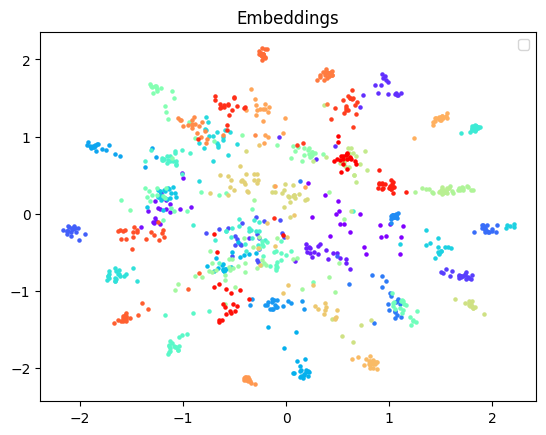

0.6876902362614375

In [6]:
from torch.utils.data import TensorDataset
from ptsne import train_parametric_tsne_model
from ptsne.config import Config
from ptsne.ptsne_net import model

config = Config()
print(f"Training on {config.dev}", flush=True)
trainfs = [f for f, l in ds.feats]
trainlbs = [l for f, l in ds.feats]

dim_input = trainfs[0].shape[0]
net = model(dim_input).to(device)

fs = torch.stack(trainfs).to(device)
lbs = torch.tensor(trainlbs)
trainset = TensorDataset(fs, lbs)
train_parametric_tsne_model(net, trainset, dim_input, config)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)).cpu().squeeze() for f,l in dstest.feats], [l for f,l in dstest.feats]

plotsmart(np.array(fs), lbs, "Embeddings", True)

ranks = getallranks(fs)
resmap = calcmap(ranks, lbs)
res['p-tsne'].append(resmap)
resmap

**P-UMAP**

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Mon Dec 16 13:44:22 2024 Building RP forest with 8 trees
Mon Dec 16 13:44:24 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | encoder | default_encoder | 388 K  | train
----------------------------------------------------
388 K     Trainable params
0         Non-trainable params
388 K     Total params
1.553     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/de/miniconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider incre

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reducing array of shape torch.Size([1000, 1536]) to (1000, 2)


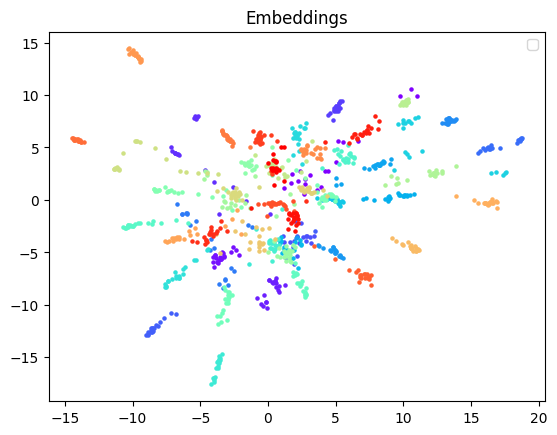

0.716935991173991

In [7]:
import sys

try:
    from umap_pytorch import PUMAP
except ImportError:
    print("Pacote 'umap-pytorch' não encontrado. Instalando...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-pytorch"])
    from umap_pytorch import PUMAP 

pumap = PUMAP(
        encoder=None,           # nn.Module, None for default
        decoder=None,           # nn.Module, True for default, None for encoder only
        n_neighbors=10,
        min_dist=0.1,
        metric="euclidean",
        n_components=2,
        beta=1.0,               # How much to weigh reconstruction loss for decoder
        reconstruction_loss=F.binary_cross_entropy_with_logits, # pass in custom reconstruction loss functions
        random_state=None,
        lr=1e-3,
        epochs=10,
        batch_size=64,
        num_workers=1,
        num_gpus=1,
        match_nonparametric_umap=False # Train network to match embeddings from non parametric umap
)

pumap.fit(torch.stack(trainfs))

fs = [f for f, l in dstest.feats]
lbs = [l for f, l in dstest.feats]

embedding = pumap.transform(torch.stack(fs))
plotsmart(embedding, lbs, "Embeddings", True)

ranks = getallranks([torch.tensor(e) for e in embedding])
resmap = calcmap(ranks, lbs)
res['p-umap'].append(resmap)
resmap

**FOLD 2**

/tmp/ipykernel_48042/1510937138.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
/tmp/ipykernel_48042/1510937138.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]


Training on cuda


100%|██████████| 8/8 [00:00<00:00, 16.23it/s]

====> Epoch: 1. Time 0:00:00.493653. Average loss: 10.8955



100%|██████████| 8/8 [00:00<00:00, 14.59it/s]

====> Epoch: 2. Time 0:00:00.549201. Average loss: 1.0486



100%|██████████| 8/8 [00:00<00:00, 14.67it/s]

====> Epoch: 3. Time 0:00:00.546063. Average loss: 0.6888



100%|██████████| 8/8 [00:00<00:00, 16.08it/s]

====> Epoch: 4. Time 0:00:00.498220. Average loss: 0.5135



100%|██████████| 8/8 [00:00<00:00, 14.66it/s]

====> Epoch: 5. Time 0:00:00.546458. Average loss: 0.4076



100%|██████████| 8/8 [00:00<00:00, 14.51it/s]

====> Epoch: 6. Time 0:00:00.551793. Average loss: 0.3388



100%|██████████| 8/8 [00:00<00:00, 14.61it/s]

====> Epoch: 7. Time 0:00:00.548314. Average loss: 0.2867



100%|██████████| 8/8 [00:00<00:00, 14.68it/s]

====> Epoch: 8. Time 0:00:00.545713. Average loss: 0.2495



100%|██████████| 8/8 [00:00<00:00, 15.39it/s]

====> Epoch: 9. Time 0:00:00.520528. Average loss: 0.2214



100%|██████████| 8/8 [00:00<00:00, 19.47it/s]

====> Epoch: 10. Time 0:00:00.411619. Average loss: 0.1985
Training time: 0:00:05.213311



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Mon Dec 16 13:48:37 2024 Building RP forest with 8 trees
Mon Dec 16 13:48:37 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | encoder | default_encoder | 388 K  | train
----------------------------------------------------
388 K     Trainable params
0         Non-trainable params
388 K     Total params
1.553     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/de/miniconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reducing array of shape torch.Size([1000, 1536]) to (1000, 2)


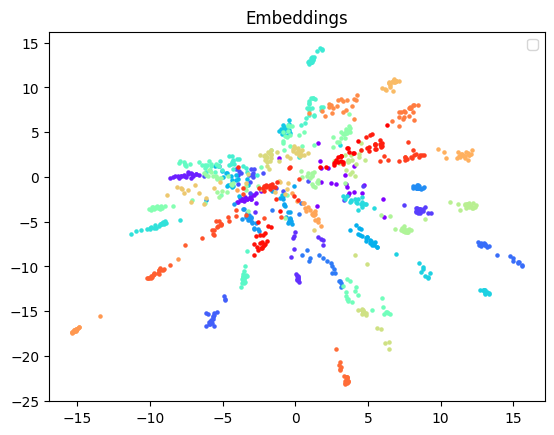

0.716537947315647

In [8]:
idfold = 1 # = Fold 2
imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)

from ptsne import train_parametric_tsne_model
from ptsne.config import Config
from ptsne.ptsne_net import model

config = Config()
print(f"Training on {config.dev}", flush=True)
trainfs = [f for f, l in ds.feats]
trainlbs = [l for f, l in ds.feats]

dim_input = trainfs[0].shape[0]
net = model(dim_input).to(device)

fs = torch.stack(trainfs).to(device)
lbs = torch.tensor(trainlbs)
trainset = TensorDataset(fs, lbs)
train_parametric_tsne_model(net, trainset, dim_input, config)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)).cpu().squeeze() for f,l in dstest.feats], [l for f,l in dstest.feats]

ranks = getallranks(fs)
resmap = calcmap(ranks, lbs)
res['p-tsne'].append(resmap)
resmap


# ===============================================================================================
#                    P-UMAP
# ===============================================================================================



import sys

try:
    from umap_pytorch import PUMAP
except ImportError:
    print("Pacote 'umap-pytorch' não encontrado. Instalando...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-pytorch"])
    from umap_pytorch import PUMAP 

pumap = PUMAP(
        encoder=None,           # nn.Module, None for default
        decoder=None,           # nn.Module, True for default, None for encoder only
        n_neighbors=10,
        min_dist=0.1,
        metric="euclidean",
        n_components=2,
        beta=1.0,               # How much to weigh reconstruction loss for decoder
        reconstruction_loss=F.binary_cross_entropy_with_logits, # pass in custom reconstruction loss functions
        random_state=None,
        lr=1e-3,
        epochs=10,
        batch_size=64,
        num_workers=1,
        num_gpus=1,
        match_nonparametric_umap=False # Train network to match embeddings from non parametric umap
)

pumap.fit(torch.stack(trainfs))

fs = [f for f, l in dstest.feats]
lbs = [l for f, l in dstest.feats]

embedding = pumap.transform(torch.stack(fs))

ranks = getallranks([torch.tensor(e) for e in embedding])
resmap = calcmap(ranks, lbs)
res['p-umap'].append(resmap)
resmap

**FOLD 3**

In [9]:
idfold = 2 # = Fold 2
imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)

from ptsne import train_parametric_tsne_model
from ptsne.config import Config
from ptsne.ptsne_net import model

config = Config()
print(f"Training on {config.dev}", flush=True)
trainfs = [f for f, l in ds.feats]
trainlbs = [l for f, l in ds.feats]

dim_input = trainfs[0].shape[0]
net = model(dim_input).to(device)

fs = torch.stack(trainfs).to(device)
lbs = torch.tensor(trainlbs)
trainset = TensorDataset(fs, lbs)
train_parametric_tsne_model(net, trainset, dim_input, config)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)).cpu().squeeze() for f,l in dstest.feats], [l for f,l in dstest.feats]

ranks = getallranks(fs)
resmap = calcmap(ranks, lbs)
res['p-tsne'].append(resmap)
resmap


# ===============================================================================================
#                    P-UMAP
# ===============================================================================================



import sys

try:
    from umap_pytorch import PUMAP
except ImportError:
    print("Pacote 'umap-pytorch' não encontrado. Instalando...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-pytorch"])
    from umap_pytorch import PUMAP 

pumap = PUMAP(
        encoder=None,           # nn.Module, None for default
        decoder=None,           # nn.Module, True for default, None for encoder only
        n_neighbors=10,
        min_dist=0.1,
        metric="euclidean",
        n_components=2,
        beta=1.0,               # How much to weigh reconstruction loss for decoder
        reconstruction_loss=F.binary_cross_entropy_with_logits, # pass in custom reconstruction loss functions
        random_state=None,
        lr=1e-3,
        epochs=10,
        batch_size=64,
        num_workers=1,
        num_gpus=1,
        match_nonparametric_umap=False # Train network to match embeddings from non parametric umap
)

pumap.fit(torch.stack(trainfs))

fs = [f for f, l in dstest.feats]
lbs = [l for f, l in dstest.feats]

embedding = pumap.transform(torch.stack(fs))

ranks = getallranks([torch.tensor(e) for e in embedding])
resmap = calcmap(ranks, lbs)
res['p-umap'].append(resmap)
resmap

/tmp/ipykernel_48042/1903354167.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
/tmp/ipykernel_48042/1903354167.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]


Training on cuda


100%|██████████| 8/8 [00:00<00:00, 29.11it/s]

====> Epoch: 1. Time 0:00:00.275680. Average loss: 10.7773



100%|██████████| 8/8 [00:00<00:00, 16.16it/s]

====> Epoch: 2. Time 0:00:00.495893. Average loss: 1.0422



100%|██████████| 8/8 [00:00<00:00, 18.16it/s]

====> Epoch: 3. Time 0:00:00.441106. Average loss: 0.6871



100%|██████████| 8/8 [00:00<00:00, 14.55it/s]

====> Epoch: 4. Time 0:00:00.550177. Average loss: 0.5127



100%|██████████| 8/8 [00:00<00:00, 14.66it/s]

====> Epoch: 5. Time 0:00:00.546160. Average loss: 0.4071



100%|██████████| 8/8 [00:00<00:00, 14.54it/s]

====> Epoch: 6. Time 0:00:00.550799. Average loss: 0.3368



100%|██████████| 8/8 [00:00<00:00, 16.28it/s]

====> Epoch: 7. Time 0:00:00.492239. Average loss: 0.2865



100%|██████████| 8/8 [00:00<00:00, 15.23it/s]

====> Epoch: 8. Time 0:00:00.525993. Average loss: 0.2491



100%|██████████| 8/8 [00:00<00:00, 35.15it/s]

====> Epoch: 9. Time 0:00:00.228223. Average loss: 0.2208



100%|██████████| 8/8 [00:00<00:00, 42.36it/s]

====> Epoch: 10. Time 0:00:00.189628. Average loss: 0.1978
Training time: 0:00:04.297403



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Mon Dec 16 13:52:36 2024 Building RP forest with 8 trees
Mon Dec 16 13:52:36 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | encoder | default_encoder | 388 K  | train
----------------------------------------------------
388 K     Trainable params
0         Non-trainable params
388 K     Total params
1.553     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/de/miniconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Reducing array of shape torch.Size([1000, 1536]) to (1000, 2)


0.756523627896041

**FOLD 4**

In [10]:
idfold = 3 # = Fold 2
imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)

from ptsne import train_parametric_tsne_model
from ptsne.config import Config
from ptsne.ptsne_net import model

config = Config()
print(f"Training on {config.dev}", flush=True)
trainfs = [f for f, l in ds.feats]
trainlbs = [l for f, l in ds.feats]

dim_input = trainfs[0].shape[0]
net = model(dim_input).to(device)

fs = torch.stack(trainfs).to(device)
lbs = torch.tensor(trainlbs)
trainset = TensorDataset(fs, lbs)
train_parametric_tsne_model(net, trainset, dim_input, config)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)).cpu().squeeze() for f,l in dstest.feats], [l for f,l in dstest.feats]

ranks = getallranks(fs)
resmap = calcmap(ranks, lbs)
res['p-tsne'].append(resmap)
resmap

# ===============================================================================================
#                    P-UMAP
# ===============================================================================================

pumap = PUMAP(
        encoder=None,           # nn.Module, None for default
        decoder=None,           # nn.Module, True for default, None for encoder only
        n_neighbors=10,
        min_dist=0.1,
        metric="euclidean",
        n_components=2,
        beta=1.0,               # How much to weigh reconstruction loss for decoder
        reconstruction_loss=F.binary_cross_entropy_with_logits, # pass in custom reconstruction loss functions
        random_state=None,
        lr=1e-3,
        epochs=10,
        batch_size=64,
        num_workers=1,
        num_gpus=1,
        match_nonparametric_umap=False # Train network to match embeddings from non parametric umap
)

pumap.fit(torch.stack(trainfs))

fs = [f for f, l in dstest.feats]
lbs = [l for f, l in dstest.feats]

embedding = pumap.transform(torch.stack(fs))

ranks = getallranks([torch.tensor(e) for e in embedding])
resmap = calcmap(ranks, lbs)
res['p-umap'].append(resmap)
resmap

/tmp/ipykernel_48042/1464832672.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
/tmp/ipykernel_48042/1464832672.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]


Training on cuda


100%|██████████| 8/8 [00:00<00:00, 42.30it/s]

====> Epoch: 1. Time 0:00:00.190152. Average loss: 10.7546



100%|██████████| 8/8 [00:00<00:00, 38.93it/s]

====> Epoch: 2. Time 0:00:00.206160. Average loss: 1.0379



100%|██████████| 8/8 [00:00<00:00, 43.07it/s]

====> Epoch: 3. Time 0:00:00.186455. Average loss: 0.6820



100%|██████████| 8/8 [00:00<00:00, 14.54it/s]

====> Epoch: 4. Time 0:00:00.551216. Average loss: 0.5087



100%|██████████| 8/8 [00:00<00:00, 16.37it/s]

====> Epoch: 5. Time 0:00:00.489256. Average loss: 0.4035



100%|██████████| 8/8 [00:00<00:00, 14.43it/s]

====> Epoch: 6. Time 0:00:00.554980. Average loss: 0.3337



100%|██████████| 8/8 [00:00<00:00, 18.19it/s]

====> Epoch: 7. Time 0:00:00.440631. Average loss: 0.2869



100%|██████████| 8/8 [00:00<00:00, 15.47it/s]

====> Epoch: 8. Time 0:00:00.517799. Average loss: 0.2473



100%|██████████| 8/8 [00:00<00:00, 14.57it/s]

====> Epoch: 9. Time 0:00:00.549718. Average loss: 0.2205



100%|██████████| 8/8 [00:00<00:00, 15.93it/s]

====> Epoch: 10. Time 0:00:00.502915. Average loss: 0.1968
Training time: 0:00:04.191197



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Mon Dec 16 13:54:58 2024 Building RP forest with 8 trees
Mon Dec 16 13:54:58 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | encoder | default_encoder | 388 K  | train
----------------------------------------------------
388 K     Trainable params
0         Non-trainable params
388 K     Total params
1.553     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/home/de/miniconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Reducing array of shape torch.Size([1000, 1536]) to (1000, 2)


0.7708977967677211

**FOLD 5**

In [11]:
idfold = 4 # = Fold 2
imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
lbstrain   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][0]]

imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]
lbstest   = [torch.tensor(y[idx]) for idx in crossidxs[idfold][1]]

ds = CustomDataset(imgstrain, lbstrain, None, train_dataset.classes)
dstest = CustomDataset(imgstest, lbstest, None, train_dataset.classes)

configfeats(ds)
configfeats(dstest)

from ptsne import train_parametric_tsne_model
from ptsne.config import Config
from ptsne.ptsne_net import model

config = Config()
print(f"Training on {config.dev}", flush=True)
trainfs = [f for f, l in ds.feats]
trainlbs = [l for f, l in ds.feats]

dim_input = trainfs[0].shape[0]
net = model(dim_input).to(device)

fs = torch.stack(trainfs).to(device)
lbs = torch.tensor(trainlbs)
trainset = TensorDataset(fs, lbs)
train_parametric_tsne_model(net, trainset, dim_input, config)

net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)).cpu().squeeze() for f,l in dstest.feats], [l for f,l in dstest.feats]

ranks = getallranks(fs)
resmap = calcmap(ranks, lbs)
res['p-tsne'].append(resmap)
resmap

# ===============================================================================================
#                    P-UMAP
# ===============================================================================================

pumap = PUMAP(
        encoder=None,           # nn.Module, None for default
        decoder=None,           # nn.Module, True for default, None for encoder only
        n_neighbors=10,
        min_dist=0.1,
        metric="euclidean",
        n_components=2,
        beta=1.0,               # How much to weigh reconstruction loss for decoder
        reconstruction_loss=F.binary_cross_entropy_with_logits, # pass in custom reconstruction loss functions
        random_state=None,
        lr=1e-3,
        epochs=10,
        batch_size=64,
        num_workers=1,
        num_gpus=1,
        match_nonparametric_umap=False # Train network to match embeddings from non parametric umap
)

pumap.fit(torch.stack(trainfs))

fs = [f for f, l in dstest.feats]
lbs = [l for f, l in dstest.feats]

embedding = pumap.transform(torch.stack(fs))

ranks = getallranks([torch.tensor(e) for e in embedding])
resmap = calcmap(ranks, lbs)
res['p-umap'].append(resmap)
resmap

/tmp/ipykernel_48042/897998413.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstrain = [torch.tensor(x[idx]) for idx in crossidxs[idfold][0]]
/tmp/ipykernel_48042/897998413.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgstest = [torch.tensor(x[idx]) for idx in crossidxs[idfold][1]]


Training on cuda


100%|██████████| 8/8 [00:00<00:00, 23.45it/s]

====> Epoch: 1. Time 0:00:00.341812. Average loss: 10.7658



100%|██████████| 8/8 [00:00<00:00, 14.52it/s]

====> Epoch: 2. Time 0:00:00.551593. Average loss: 1.0413



100%|██████████| 8/8 [00:00<00:00, 15.34it/s]

====> Epoch: 3. Time 0:00:00.522175. Average loss: 0.6847



100%|██████████| 8/8 [00:00<00:00, 15.23it/s]

====> Epoch: 4. Time 0:00:00.525825. Average loss: 0.5097



100%|██████████| 8/8 [00:00<00:00, 15.22it/s]

====> Epoch: 5. Time 0:00:00.526288. Average loss: 0.4044



100%|██████████| 8/8 [00:00<00:00, 15.34it/s]

====> Epoch: 6. Time 0:00:00.522300. Average loss: 0.3367



100%|██████████| 8/8 [00:00<00:00, 14.58it/s]

====> Epoch: 7. Time 0:00:00.549133. Average loss: 0.2851



100%|██████████| 8/8 [00:00<00:00, 14.50it/s]

====> Epoch: 8. Time 0:00:00.552501. Average loss: 0.2483



100%|██████████| 8/8 [00:00<00:00, 15.30it/s]

====> Epoch: 9. Time 0:00:00.523373. Average loss: 0.2206



100%|██████████| 8/8 [00:00<00:00, 15.26it/s]

====> Epoch: 10. Time 0:00:00.525140. Average loss: 0.1971
Training time: 0:00:05.141862



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Mon Dec 16 13:57:22 2024 Building RP forest with 8 trees
Mon Dec 16 13:57:22 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | encoder | default_encoder | 388 K  | train
----------------------------------------------------
388 K     Trainable params
0         Non-trainable params
388 K     Total params
1.553     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


	Stopping threshold met -- exiting after 5 iterations


/home/de/miniconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Reducing array of shape torch.Size([1000, 1536]) to (1000, 2)


0.7333682011817924

**Resultados**

In [12]:
res

{'p-tsne': [0.6876902362614375,
  0.6518689380449187,
  0.6913980211699947,
  0.7171410431300258,
  0.6972573733708926],
 'p-umap': [0.716935991173991,
  0.716537947315647,
  0.756523627896041,
  0.7708977967677211,
  0.7333682011817924]}

In [13]:
[{r: np.mean(res[r]) } for r in res]

[{'p-tsne': 0.6890711223954539}, {'p-umap': 0.7388527128670385}]